In [1]:
import pandas as pd
import numpy as np

# ustawiamy ziarnko (seed), dla powtarzalności w losowaniu
np.random.seed(1) # <== może być dowolna liczba, ale trzeba wybrać coś... np. 1

# models (algorithms)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# walidacja wyniku (po to, żeby walczyć z przeuczeniem się modelu)
from sklearn.model_selection import train_test_split

# metryka sukcesu
from sklearn.metrics import accuracy_score

# wizualizacja
import matplotlib.pyplot as plt

# umożliwia prezentowanie wykresów w notebooku
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


In [2]:
df = pd.read_csv("/Users/p/Documents/dev/Machine-Learning/001-basic-intro_python_numpy_pandas/input/polish_names.csv")
df['target'] = df['gender'].map(lambda x: 1 if x == 'm' else 0)

In [3]:
def train_and_predict_model(X_train, X_test, y_train, y_test, model, success_metric=accuracy_score):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("Distribution:")
    print(pd.Series(y_pred).value_counts())

    return success_metric(y_test, y_pred)

In [4]:
vowels = ['a', 'ą', 'e', 'ę', 'i', 'o', 'u', 'y']

def how_many_vowels(name):
    return sum(map(lambda x: int(x in vowels), name.lower()) )

def first_is_vowel(name):
    return name.lower()[0] in vowels

def last_is_vowel(name):
    return name.lower()[-1] in vowels

def get_all_vowels(name):
    all_vowels = [letter for letter in name.lower() if letter in vowels]
    return ''.join(all_vowels)

def get_all_consonants(name):
    all_consonants = [letter for letter in name.lower() if letter not in vowels]

    return ''.join(all_consonants)

def feature_engineering(df):
    df['len_name'] = df['name'].map(lambda x: len(x))

    df['first_is_vowel'] = df['name'].map(first_is_vowel)
    df['last_is_vowel'] = df['name'].map(last_is_vowel)

    df['first_letter'] = df['name'].map(lambda x: x.lower()[0])
    df['first_letter_cnt'] = pd.factorize(df['first_letter'])[0]

    df['last_letter'] = df['name'].map(lambda x: x.lower()[-1])
    df['last_letter_cnt'] = pd.factorize(df['last_letter'])[0]

    df['all_vowels'] = df['name'].map(get_all_vowels)
    df['all_vowels_cnt'] = pd.factorize(df['all_vowels'])[0]

    df['all_consonants'] = df['name'].map(get_all_consonants)
    df['all_consonants_cnt'] = pd.factorize(df['all_consonants'])[0]


    return df

In [6]:
df_fe = feature_engineering(df.copy())

In [7]:
df.head(5)

,name,gender,target
0,Abdon,m,1
1,Abel,m,1
2,Abercjusz,m,1
3,Abraham,m,1
4,Absalon,m,1


In [8]:
df_fe.head(5)

,name,gender,target,len_name,first_is_vowel,last_is_vowel,first_letter,first_letter_cnt,last_letter,last_letter_cnt,all_vowels,all_vowels_cnt,all_consonants,all_consonants_cnt
0,Abdon,m,1,5,True,False,a,0,n,0,ao,0,bdn,0
1,Abel,m,1,4,True,False,a,0,l,1,ae,1,bl,1
2,Abercjusz,m,1,9,True,False,a,0,z,2,aeu,2,brcjsz,2
3,Abraham,m,1,7,True,False,a,0,m,3,aaa,3,brhm,3
4,Absalon,m,1,7,True,False,a,0,n,0,aao,4,bsln,4


In [10]:
features = ['len_name', 'first_is_vowel', 'last_is_vowel', 'first_letter_cnt', 'last_letter_cnt', 'all_vowels_cnt', 'all_consonants_cnt']
X = df_fe[features]
y = df_fe['target']

train_and_predict_model(X, X, y, y, LogisticRegression(solver='lbfgs', max_iter=300))

Distribution:
1    964
0    741
Name: count, dtype: int64


0.9524926686217009

### Train & Test

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (1193, 7) (1193,)
Test: (512, 7) (512,)


### LogisticRegression

In [12]:
train_and_predict_model(X_train, X_test, y_train, y_test, LogisticRegression(solver='lbfgs', max_iter=300))

Distribution:
1    291
0    221
Name: count, dtype: int64


0.951171875

### Krzywe uczenia się (ang. learning curves)

In [13]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(model, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None:plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Interpretacja wyników:

•	Różnica między treningiem a walidacją: Jeśli różnica między wynikami treningowymi i walidacyjnymi jest duża, model może być przeuczony.

•	Stabilizacja krzywych: Jeżeli obie krzywe zbliżają się do siebie, model dobrze generalizuje.

•	Zbieżność w niskim wyniku: Jeśli wyniki są niskie dla obu zbiorów, model może być niedouczony.

/Users/p/Documents/dev/Machine-Learning/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


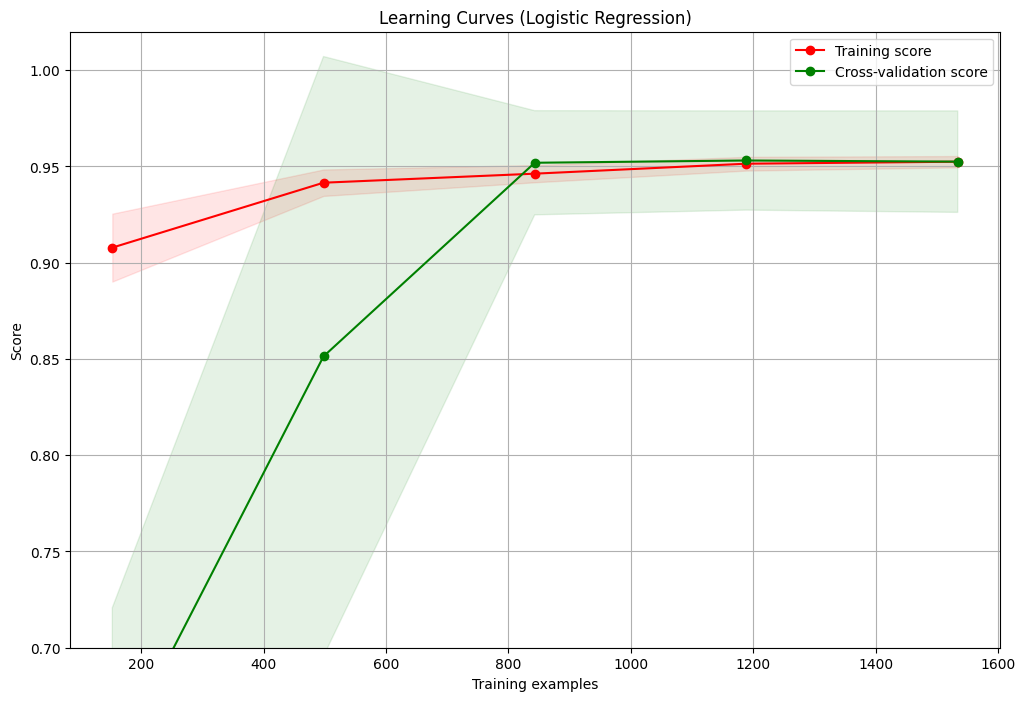

In [14]:
plt = plot_learning_curve(LogisticRegression(solver='lbfgs', max_iter=300), "Learning Curves (Logistic Regression)", X, y, ylim=(0.7, 1.02), cv=10, n_jobs=4)
plt.show()

### DecisionTreeClassifier

In [15]:
train_and_predict_model(X_train, X_test, y_train, y_test, DecisionTreeClassifier())

Distribution:
1    311
0    201
Name: count, dtype: int64


0.982421875

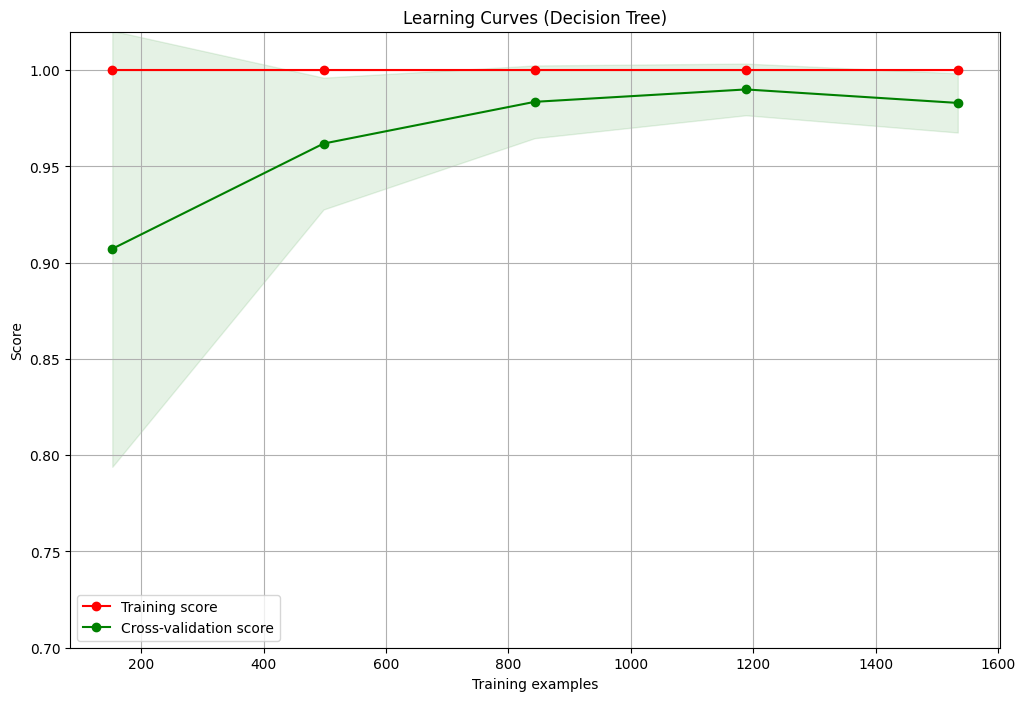

In [16]:
plt = plot_learning_curve(DecisionTreeClassifier(), "Learning Curves (Decision Tree)", X, y, ylim=(0.7, 1.02), cv=10)
plt.show()